# NuMI at MicroBooNE Oscillaton Analysis

In [9]:
#import libraries
import sys
from scipy.stats import norm
import scipy.stats

import importlib
import numpy as np
import math

import seaborn as sns
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from IPython.display import set_matplotlib_formats
%matplotlib inline
set_matplotlib_formats('svg')
from matplotlib import rcParams
import matplotlib.cm as cm 
import matplotlib.lines as mlines

import pandas as pd
import awkward
import uproot
import uproot_methods.classes.TH2
import csv

#from progressbar import ProgressBar

#print all output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# block warnings about making highly fragmented dfs
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
simplefilter(action='ignore', category=FutureWarning)

In [5]:
# -------- SETTINGS ---------
save = True
savefile = "./osc_check/"
import_path = "/uboone/app/users/kmiller/searchingfornues_v33/uBNuMI_CC1eNp/mun/"

Ebin_n = 45
Ebin_int = 0.1
Lbin_n = 20
Lbin_int = 0.05

bins_E = np.array([i/100 for i in range(0,460, 10)])
bins_L = np.array([i/100 for i in range(0,105,5)])

bin_centers_E = (bins_E[1:]+bins_E[:-1])/2.
bin_centers_L = (bins_L[1:]+bins_L[:-1])/2.

In [6]:
# function to rebin flux histos
def bin_ndarray(ndarray, new_shape, operation='sum'):
    operation = operation.lower()
    if not operation in ['sum', 'mean']:
        raise ValueError("Operation not supported.")
    if ndarray.ndim != len(new_shape):
        raise ValueError("Shape mismatch: {} -> {}".format(ndarray.shape,
                                                           new_shape))
    compression_pairs = [(d, c//d) for d,c in zip(new_shape,
                                                  ndarray.shape)]
    flattened = [l for p in compression_pairs for l in p]
    ndarray = ndarray.reshape(flattened)
    for i in range(len(new_shape)):
        op = getattr(ndarray, operation)
        ndarray = op(-1*(i+1))
    return ndarray

In [7]:
# print a chi2 - sigma table
dof = range(1,11)
sigmas = [ 1.0, math.sqrt(scipy.stats.chi2.ppf(0.9,1)), math.sqrt(scipy.stats.chi2.ppf(0.99,1)), 3.0, 5.0]
conf_int = [ scipy.stats.chi2.cdf( s**2,1) for s in sigmas]

print("sigma     \t" + "\t".join(["%1.2f"%(s) for s in sigmas]))
print("conf_int  \t" + "\t".join(["%1.2f%%"%(100*ci) for ci in conf_int]))
print("p-value   \t" + "\t".join(["%1.5f"%(1-ci) for ci in conf_int]))

for d in dof:
    chi_squared = [ scipy.stats.chi2.ppf( ci, d) for ci in conf_int ]
    print("chi2(k=%d)\t"%d + "\t".join(["%1.2f" % c for c in chi_squared]))

sigma     	1.00	1.64	2.58	3.00	5.00
conf_int  	68.27%	90.00%	99.00%	99.73%	100.00%
p-value   	0.31731	0.10000	0.01000	0.00270	0.00000
chi2(k=1)	1.00	2.71	6.63	9.00	25.00
chi2(k=2)	2.30	4.61	9.21	11.83	28.74
chi2(k=3)	3.53	6.25	11.34	14.16	31.81
chi2(k=4)	4.72	7.78	13.28	16.25	34.56
chi2(k=5)	5.89	9.24	15.09	18.21	37.09
chi2(k=6)	7.04	10.64	16.81	20.06	39.49
chi2(k=7)	8.18	12.02	18.48	21.85	41.78
chi2(k=8)	9.30	13.36	20.09	23.57	43.98
chi2(k=9)	10.42	14.68	21.67	25.26	46.12
chi2(k=10)	11.54	15.99	23.21	26.90	48.19


In [10]:
#import ROOT flux analysis histogram
file = uproot.open('/uboone/data/users/munjung/OscillationAnalysis/oscillated_numi_flux/analysisPlotsFHC_May12.root')

flavors = ['numu', 'numubar', 'nue', 'nuebar']

hist_dict = dict()
for i in flavors:
    hist_dict[i + '_hist'] = file[i][i+'_LEFlux']
    hist_dict[i + '_hist'] = hist_dict[i + '_hist'].values
    hist_dict[i + '_hist'] = bin_ndarray(hist_dict[i + '_hist'], new_shape=(45,20), operation='sum')

# bins = [i/100 for i in range(0,455, 10)]

In [11]:
# load flux file in to pandas df
df_dict = dict()
for i in flavors:
    df_dict[i] = pd.DataFrame(columns = ['weight','E', 'L'])
        
for flavor in flavors:
    for i in range(0,45):
        for j in range(0,20):
            df_dict[flavor].loc[len(df_dict[flavor].index)] = [hist_dict[str(flavor)+"_hist"][i][j], (Ebin_int/2.)+Ebin_int*int(i), (Lbin_int/2.)+Lbin_int*int(j)] 

In [12]:
df_dict['numu']

,weight,E,L
0,0.000000,0.05,0.025
1,124.735278,0.05,0.075
2,449.963156,0.05,0.125
3,31.711048,0.05,0.175
4,20.438482,0.05,0.225
...,...,...,...
895,0.000000,4.45,0.775
896,0.000000,4.45,0.825
897,0.000000,4.45,0.875
898,0.000000,4.45,0.925


AttributeError: 'PolyCollection' object has no property 'shading'

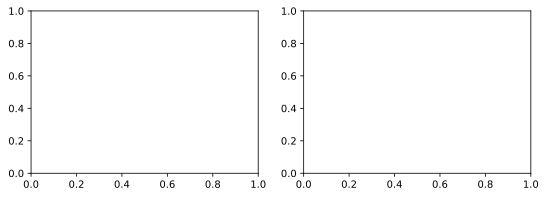

In [13]:
# check numu flux
fig, axs = plt.subplots(1, 2, figsize = (9,3))
    
fm = axs[0].pcolor(bin_centers_E, bin_centers_L, hist_dict['numu_hist'].T, cmap='BuPu', shading='nearest', norm=LogNorm(0.01,10))
cbar = fig.colorbar(fm, ax=axs[0])
cbar.set_label(label="$\\nu$ / 5 $\\times$ $10^{8}$ POT ", fontsize=10)
cbar.ax.tick_params(labelsize=8)
axs[0].set_ylim(0, 0.75)
axs[0].set_ylabel("Oscillated Distance [km]", size = 11)
axs[0].set_xlabel(r"Neutrino Energy [GeV]", size = 11)
axs[0].set_title(r"NuMI $\nu_{\mu}$ Flux", size = 11)

fm = axs[1].pcolor(bin_centers_E, bin_centers_L, hist_dict['nue_hist'].T, cmap='BuPu', shading='nearest', norm=LogNorm(0.01,10))
cbar = fig.colorbar(fm, ax=axs[1])
cbar.set_label(label="$\\nu$ / 5 $\\times$ $10^{8}$ POT ", fontsize=10)
cbar.ax.tick_params(labelsize=8)
        
axs[1].set_ylim(0, 0.75)
axs[1].set_ylabel("Oscillated Distance [km]", size = 11)
axs[1].set_xlabel(r"Neutrino Energy [GeV]", size = 11)
axs[1].set_title(r"NuMI $\nu_{e}$ Flux", size = 11)

fig.subplots_adjust(wspace=0.4)

if save == True:
    plt.savefig(savefile+"flux_2d.pdf", bbox_inches = "tight")
    
plt.show();

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (12,4))
sns.histplot(data = df_dict['numu'], x= "L", weights = "weight", ax = ax[0], bins = 20, label = r"$\nu_{\mu}$")
ax[0].set_ylabel("$\\nu$ / 5 $\\times$ $10^{8}$ POT ", fontsize=15)
ax[0].set_xlim(0, 0.8)
ax[0].set_xlabel("Oscillated Distance [km]", fontsize=15)
ax[0].legend(prop = {"size": 15})

# fig, ax = plt.subplots(figsize = (6,4))
sns.histplot(data = df_dict['nue'], x= "L", weights = "weight", ax = ax[1], bins = 20, label = r"$\nu_{e}$")
ax[1].set_ylabel("$\\nu$ / 5 $\\times$ $10^{8}$ POT ", fontsize=15)
ax[1].set_xlabel("Oscillated Distance [km]", fontsize=15)
ax[1].set_xlim(0, 0.8)
ax[1].legend(prop = {"size": 15})

if save == True:
    plt.savefig(savefile+"flux_Lprojection.pdf", bbox_inches = "tight")

plt.show();

In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (10,3))
# sns.histplot(data = df_dict['numu'], x= "E", weights = "weight", ax = ax[0], bins = 20, label = r"$\nu_{\mu}$")
nmu, bins, _ = ax[0].hist(df_dict['numu']["E"], weights = df_dict['numu']["weight"], histtype = "step", bins = np.linspace(0,2,21), label = r"$\nu_{\mu}$")
# ax[0].set_yscale("log")
ax[0].set_ylabel("$\\nu$ / 5 $\\times$ $10^{8}$ POT ", fontsize=15)
ax[0].set_xlabel(r"Neutrino Energy [GeV]", fontsize=15)
ax[0].legend(prop = {"size": 15})


# fig, ax = plt.subplots(figsize = (6,4))
# sns.histplot(data = df_dict['nue'], x= "E", weights = "weight", ax = ax[1], bins = 20, label = r"$\nu_{e}$")
ne, bins, _ = ax[1].hist(df_dict['nue']["E"], weights = df_dict['nue']["weight"], histtype = "step", bins = np.linspace(0,4.5,46), label = r"$\nu_{e}$")
# ax[1].set_yscale("log")
ax[1].set_ylabel("$\\nu$ / 5 $\\times$ $10^{8}$ POT ", fontsize=15)
ax[1].set_xlabel(r"Neutrino Energy [GeV]", fontsize=15)
ax[1].legend(prop = {"size": 15})


plt.show();

In [ ]:
var = [df_dict['numu']["E"], df_dict['nue']["E"]]
weights = [df_dict['numu']["weight"], df_dict['nue']["weight"]]
labels = [ r"$\nu_{\mu}$",  r"$\nu_{e}$"]

fig, ax = plt.subplots(1, 2, figsize = (12,4))

ax[0].hist(var, weights = weights, histtype = "step", bins = np.linspace(0,4.5,46), label =labels)
ax[0].set_ylabel("$\\nu$ / 5 $\\times$ $10^{8}$ POT ", fontsize=15)
ax[0].set_xlabel(r"Neutrino Energy [GeV]", fontsize=15)
# ax[0].set_xlim(0.2, 4.5)
ax[0].legend(prop = {"size": 15})
ax[0].axvline(1, color = "r")

ax[1].hist(var, weights = weights, histtype = "step", bins = np.linspace(0,4.5,46), label =labels)
ax[1].set_ylabel("$\\nu$ / 5 $\\times$ $10^{8}$ POT ", fontsize=15)
ax[1].set_xlabel(r"Neutrino Energy [GeV]", fontsize=15)
ax[1].legend(prop = {"size": 15})
# ax[1].set_xlim(0.2, 4.5)
ax[1].set_yscale("log")
ax[1].axvline(1, color = "r")

if save == True:
    plt.savefig(savefile+"flux_logscale.pdf", bbox_inches = "tight")


plt.show();

# OSC

In [ ]:
fit_option = [0,1,2]
ss2t = [0.003, 0.00631, 0.0015]
dms = [1.2, 0.559, 1.6]

#######sterile neutrino oscillation functions########
def numu_to_nue_sterile(L, E, fit_option):
    osc_prob = ss2t[fit_option]*(np.sin(1.27*dms[fit_option]*L/(E)))**2
    return osc_prob

def numu_to_numu_sterile(L, E, fit_option):
    osc_prob = ss2t[fit_option]*(np.sin(1.27*dms[fit_option]*L/(E)))**2
    return 1-osc_prob   


# #######sterile neutrino oscillation functions########
# def numu_to_nue_sterile(L, E, fit_option):
#     L = 1
#     osc_prob = ss2t[fit_option]*(np.sin(1.27*dms[fit_option]*L/(E)))**2
#     return osc_prob

# def numu_to_numu_sterile(L, E, fit_option):
#     L = 1
#     osc_prob = ss2t[fit_option]*(np.sin(1.27*dms[fit_option]*L/(E)))**2
#     return 1-osc_prob   


In [ ]:
for i in range(len(fit_option)):
    df_dict['numu']["osc_prob_app" + str(i)] = numu_to_nue_sterile(df_dict['numu']["L"], df_dict['numu']["E"], i)
    df_dict['numu']["osc_weight_app" + str(i)] = df_dict['numu']["osc_prob_app" + str(i)]*df_dict['numu']["weight"]
    

In [ ]:
E_edges = df_dict['numu']["E"].unique()
i = 0
muE_cut = []
eE_cut = []
for i in range(len(E_edges) - 1):
    muE_cut.append((df_dict['numu']["E"] > E_edges[i]) & (df_dict['numu']["E"] <= E_edges[i+1]))
    eE_cut.append((df_dict['nue']["E"] > E_edges[i]) & (df_dict['nue']["E"] <= E_edges[i+1]))

In [ ]:
df_dict['numu']["mock_osc_ratio_app1"] = (df_dict['numu']["osc_weight_app1"])/(0.7*df_dict['numu']["weight"])

fig, ax = plt.subplots()
sns.histplot(data = df_dict['numu'], x= "E", weights = "mock_osc_ratio_app1" , ax = ax, bins = 45, label = r"$\nu_{\mu}$")

# plt.show();

In [ ]:
fig, ax = plt.subplots()
sns.histplot(data = df_dict['numu'], x= "E", weights = "osc_weight_app1" , ax = ax, bins = 20, label = r"$\nu_{\mu}$")
# sns.histplot(data = 0.7*df_dict['numu'], x= "E", weights = "weight" , ax = ax, bins = 20, label = r"$\nu_{\mu}$")



## Active Oscillation Short Baseline Limit

### 3 flavor vacuum mixing - use this one

In [14]:
#numu -> nue (nue appearance)
#units: km, GeV, GeV^2/c^4, theata in radians
t_23 = np.arcsin(np.sqrt(0.558))
t_13 = np.arcsin(np.sqrt(0.02241))
t_12 = np.arcsin(np.sqrt(0.310))
dms_21 = 7.39e-5  
dms_31 = 2.5229e-3  

def numu_to_nue_active(L, E):
        
    osc_prob = (((np.sin(t_23))**2)*((np.sin(2*t_13))**2)*((np.sin(dms_31*(1.27*L)/E))**2) + ((np.cos(t_23))**2)*((np.cos(t_13))**2)*((np.sin(2*t_12))**2)*((np.sin(dms_21*(1.27*L)/E))**2))
    return osc_prob
    
def nue_to_nue_active(L, E):
        
    osc_prob = (((np.sin(2*t_13))**2)*((np.sin(dms_31*(1.27*L)/E))**2) + ((np.cos(t_13))**2)*((np.sin(2*t_12))**2)*((np.sin(dms_21*(1.27*L)/E))**2))
    return (1-osc_prob)


In [15]:
# osc probability weight
df_dict["numu"]["weight_active_app"] = numu_to_nue_active(df_dict["numu"]["L"].astype(float), df_dict["numu"]["E"].astype(float))
df_dict["nue"]["weight_active_dis"] = nue_to_nue_active(df_dict["nue"]["L"].astype(float), df_dict["nue"]["E"].astype(float))


# osc events
df_dict["numu"]["osc_active_app"] = df_dict["numu"]["weight"]*df_dict["numu"]["weight_active_app"]
df_dict["nue"]["osc_active_dis"] = df_dict["nue"]["weight"]*df_dict["nue"]["weight_active_dis"]

# groub by E
df_numu_sum = df_dict["numu"][["E", "osc_active_app"]].groupby("E").sum()
df_nue_sum = df_dict["nue"].groupby("E").sum()

# add osc flux to nue flux
df_nue_sum["osc_weight_active"] = df_nue_sum["osc_active_dis"] + df_numu_sum["osc_active_app"]
df_nue_sum["osc_ratio_active"] = df_nue_sum["osc_weight_active"]/df_nue_sum["weight"]

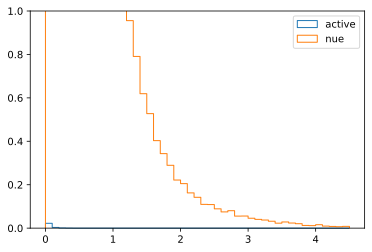

In [16]:
# plot fluxes
n_21, _, _ = plt.hist(data = df_dict["numu"], x = "E", weights = "osc_active_app", bins = bins_E, histtype="step", fill=False, label = "active") 
n, bins, _ = plt.hist(data = df_dict["nue"], x = "E", weights = "osc_active_dis", bins = bins_E, histtype="step", fill=False, label = "nue") 
plt.ylim(0,1)
plt.legend();

NameError: name 'sns' is not defined

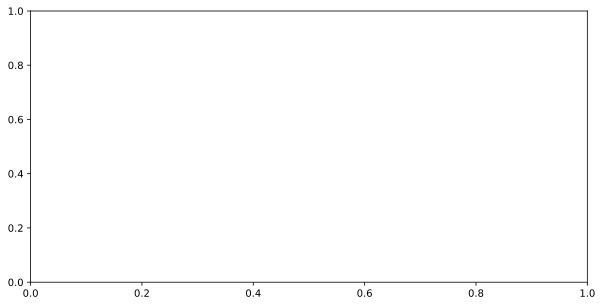

In [17]:
# plot ratio
ax, fig = plt.subplots(figsize = (10,5))
# bin_centers = (np.array(bins)[1:] + np.array(bins)[:-1])/2.
# var = [bin_centers, bin_centers]
# weights = [n_osc_21/n, n_osc_31/n]
labels =[r'3 flavor oscillation']
_ = sns.histplot(data = df_nue_sum.reset_index() , x= "E", weights = "osc_ratio_active", bins = bins_E, element="step", fill=False, label = labels[0]) 

# _ = plt.xlim(0.20,4.5)
_ = plt.xlim(0.0,4.5)
_ = plt.ylim(0.9999, 1.0008)

_ = plt.legend(prop = {"size":12});
_ = plt.xlabel("Neutrino Energy [GeV]", size = 15)
_ = plt.ylabel("Oscillated/Unoscillated", size = 15)
_ = plt.title("Active Oscillation Short Baseline 3 Flavor Oscillation", size = 15)

if save == True:
    plt.savefig(savefile + "active_SB_limit.pdf", bbox_inches = "tight");
    

## Sterile Neutrino 3+1 oscillation

In [ ]:
fit_option = [0,1,2]
ss2t = [0.003, 0.00631, 0.0015]
dms = [1.2, 0.559, 1.6]

#######sterile neutrino oscillation functions########
def numu_to_nue_sterile(L, E, fit_option):
    osc_prob = ss2t[fit_option]*(np.sin(1.27*dms[fit_option]*L/(E)))**2
    return osc_prob

def numu_to_numu_sterile(L, E, fit_option):
    osc_prob = ss2t[fit_option]*(np.sin(1.27*dms[fit_option]*L/(E)))**2
    return 1-osc_prob   


In [ ]:
df_dict = dict()
for i in flavors:
    df_dict[i] = pd.DataFrame(columns = ['weight','E', 'L'])
        
for flavor in flavors:
    for i in range(0, Ebin_n):
        for j in range(0, Lbin_n):
            df_dict[flavor].loc[len(df_dict[flavor].index)] = [hist_dict[str(flavor)+"_hist"][i][j], (Ebin_int/2.)+ Ebin_int*int(i), (Lbin_int/2.)+Lbin_int*int(j)] 

In [ ]:
df_dict["nue"]["mock_weight"] = df_dict["numu"]["weight"]*0.05
# df_dict["nue"]

In [ ]:
# numu
for i in range(len(fit_option)):
    # osc prob
    df_dict["numu"]["weight_" + str(i)] = numu_to_nue_sterile(df_dict["numu"]["L"].astype(float), df_dict["numu"]["E"].astype(float), i)
    # osc events
    df_dict["numu"]["osc_" + str(i)] = df_dict["numu"]["weight"]*df_dict["numu"]["weight_" + str(i)]

# df_dict["nue"]    
    
# # group by E
df_numu_sum = df_dict["numu"].groupby("E").sum()
df_nue_sum = df_dict["nue"].groupby("E").sum()

# df_numu_sum

for i in range(len(fit_option)):
    df_nue_sum["osc_weight_" + str(i)] = df_nue_sum["weight"] + df_numu_sum["osc_" + str(i)]
    df_nue_sum["osc_ratio_" + str(i)] = df_nue_sum["osc_weight_" + str(i)]/df_nue_sum["weight"]

    df_nue_sum["mock_osc_weight_" + str(i)] = df_nue_sum["mock_weight"] + df_numu_sum["osc_" + str(i)]
    df_nue_sum["mock_osc_ratio_" + str(i)] = df_nue_sum["mock_osc_weight_" + str(i)]/df_nue_sum["mock_weight"]

    
# df_nue_sum

In [ ]:
# plot props-------------------------------------------------------------
title = r'$\nu_{\mu} \rightarrow \nu_e$ Oscillation (Appearance) Only'
labels = ["LSND", r"global $\nu_e$ appearance", "global inclusive"]
colors = ["b", "r", "g"]
# ------------------------------------------------------------------------

f, axes = plt.subplots(2, 1, figsize=(8, 6), sharex=True, gridspec_kw={'height_ratios': [2, 1]})

for i in range(len(fit_option)):
    _ = sns.histplot(data = df_nue_sum.reset_index(), x= "E", weights = ("osc_weight_" + str(i)), ax = axes[0], bins = bins_E, element="step", fill=False, color = colors[i], label = labels[i]) 

    _ = axes[0].set_ylim(0.001, 1000)
    _ = axes[0].set_yscale('log')
    _ = axes[0].set_ylabel("Oscillated", size = 15)
    _ = axes[0].set_title(title , size = 15)
    _ = axes[0].legend(prop = {"size":12})

for i in range(len(fit_option)):
    _ = sns.histplot(data = df_nue_sum.reset_index(), x= "E", weights = ("osc_ratio_" + str(i)), ax = axes[1], bins = bins_E, element="step", fill=False, color = colors[i], label = labels[i]) 


    _ = axes[1].set_xlim(0.5,4.5)
    _ = axes[1].set_ylim(0.99, 1.1)
    _ = axes[1].set_xlabel("Neutrino Energy [GeV]", size = 15)
    _ = axes[1].set_ylabel("Osc./Unosc.", size = 15)
    _ = axes[1].legend(prop = {"size":12})

if save == True:
    plt.savefig(savefile + "sterile_appearance.pdf", bbox_inches = "tight");

In [ ]:
# plot props-------------------------------------------------------------
title = r'$\nu_{\mu} \rightarrow \nu_e$ Oscillation (Appearance) Only'
labels = ["LSND", r"global $\nu_e$ appearance", "global inclusive"]
colors = ["b", "r", "g"]
# ------------------------------------------------------------------------

f, axes = plt.subplots(2, 1, figsize=(8, 6), sharex=True, gridspec_kw={'height_ratios': [2, 1]})

for i in range(len(fit_option)):
    _ = sns.histplot(data = df_nue_sum.reset_index(), x= "E", weights = ("mock_osc_weight_" + str(i)), ax = axes[0], bins = bins_E, element="step", fill=False, color = colors[i], label = labels[i]) 

    _ = axes[0].set_ylim(0.001, 1000)
    _ = axes[0].set_yscale('log')
    _ = axes[0].set_ylabel("Oscillated", size = 15)
    _ = axes[0].set_title(title , size = 15)
    _ = axes[0].legend(prop = {"size":12})

for i in range(len(fit_option)):
    _ = sns.histplot(data = df_nue_sum.reset_index(), x= "E", weights = ("mock_osc_ratio_" + str(i)), ax = axes[1], bins = bins_E, element="step", fill=False, color = colors[i], label = labels[i]) 


    _ = axes[1].set_xlim(0.0,4.5)
    _ = axes[1].set_ylim(0.99, 1.15)
    _ = axes[1].set_xlabel("Neutrino Energy [GeV]", size = 15)
    _ = axes[1].set_ylabel("Osc./Unosc.", size = 15)
    _ = axes[1].legend(prop = {"size":12})

if save == True:
    plt.savefig(savefile + "mock_sterile_appearance.pdf", bbox_inches = "tight");

### with nue disappearance?

In [ ]:
# global inclusive app only vs. app + disapp
fit_option_mu = [0]
ss2t_mu = [0.0015]
dms_mu = [1.6]

def numu_to_nue_sterile(L, E, fit_option):
    osc_prob = ss2t_mu[fit_option]*(np.sin(1.27*dms_mu[fit_option]*L/(E)))**2
    return osc_prob
    
def numu_to_numu_sterile(L, E, fit_option):
    osc_prob = ss2t_mu[fit_option]*(np.sin(1.27*dms_mu[fit_option]*L/(E)))**2
    return 1-osc_prob   


fit_option_e = [0]
ss2t_e = [0.04038]
dms_e = [1.3]

def nue_to_nue_sterile(L, E, fit_option):
    osc_prob = ss2t_e[fit_option]*(np.sin(1.27*dms_e[fit_option]*L/(E)))**2
    return (1-osc_prob)

In [ ]:
df_dict_d = dict()
for i in flavors:
    df_dict_d[i] = pd.DataFrame(columns = ['weight','E', 'L'])
        
for flavor in flavors:
    for i in range(0, Ebin_n):
        for j in range(0, Lbin_n):
            df_dict_d[flavor].loc[len(df_dict_d[flavor].index)] = [hist_dict[str(flavor)+"_hist"][i][j],(Ebin_int/2.)+ Ebin_int*int(i), (Lbin_int/2.)+Lbin_int*int(j)] 

In [ ]:
# numu
for i in range(len(fit_option_mu)):
    # osc prob
    df_dict_d["numu"]["weight_" + str(i)] = numu_to_nue_sterile(df_dict_d["numu"]["L"].astype(float), df_dict_d["numu"]["E"].astype(float), i)
    # osc events
    df_dict_d["numu"]["osc_" + str(i)] = df_dict_d["numu"]["weight"]*df_dict_d["numu"]["weight_" + str(i)]

# nue
for j in range(len(fit_option_e)):
    # osc prob
    df_dict_d["nue"]["weight_" + str(j)] = nue_to_nue_sterile(df_dict_d["nue"]["L"].astype(float), df_dict_d["numu"]["E"].astype(float), j)
    # osc events
    df_dict_d["nue"]["osc_" + str(j)] = df_dict_d["nue"]["weight"]*df_dict_d["nue"]["weight_" + str(j)]

# group by E
df_numu_sum_d = df_dict_d["numu"].groupby("E").sum()
df_nue_sum_d = df_dict_d["nue"].groupby("E").sum()

for i in range(len(fit_option_mu)):
    for j in range(len(fit_option_e)):
        # app only
        df_nue_sum_d["osc_weight_" + str(i)] = df_nue_sum_d["weight"] + df_numu_sum_d["osc_" + str(i)]
        df_nue_sum_d["osc_ratio_" + str(i)] = df_nue_sum_d["osc_weight_" + str(i)]/df_nue_sum_d["weight"]
        # + disapp
        df_nue_sum_d["osc_weight_" + str(i) + "_dis_" + str(j)] = df_nue_sum_d["osc_" + str(j)] + df_numu_sum_d["osc_" + str(i)]
        df_nue_sum_d["osc_ratio_" + str(i) + "_dis_" + str(j)] = df_nue_sum_d["osc_weight_" + str(i) + "_dis_" + str(j)]/df_nue_sum_d["weight"]

# df_nue_sum_d

In [ ]:
# plot props --------------------------------------------
colors_d = ["g", "y"]
labels_d = ["appearance only", "with disappearance"]
i = 0
j = 0
# -------------------------------------------------------

f, axes = plt.subplots(2, 1, figsize=(8, 6), sharex=True, gridspec_kw={'height_ratios': [2, 1]})

_ = sns.histplot(data = df_nue_sum_d.reset_index(), x= "E", weights = ("osc_weight_" + str(i)), ax = axes[0], bins = bins_E, element="step", fill=False, color = colors_d[0], label = labels_d[0]) 
_ = sns.histplot(data = df_nue_sum_d.reset_index(), x= "E", weights = ("osc_weight_" + str(i) + "_dis_" + str(j)), ax = axes[0], bins = bins_E, element="step", fill=False, color = colors_d[1], label = labels_d[1]) 
_ = axes[0].set_ylim(0.001, 1000)
_ = axes[0].set_yscale('log')
_ = axes[0].set_title(r'Oscillation with Global Inclusive Best Fit Parameters', size = 15)
_ = axes[0].set_ylabel("Oscillated", size = 15)
_ = axes[0].legend(prop = {"size":12})

_ = sns.histplot(data = df_nue_sum_d.reset_index(), x= "E", weights = ("osc_ratio_" + str(i)), ax = axes[1], bins = bins_E, element="step", fill=False, color = colors_d[0], label = labels_d[0]) 
_ = sns.histplot(data = df_nue_sum_d.reset_index(), x= "E", weights = ("osc_ratio_" + str(i) + "_dis_" + str(j)), ax = axes[1], bins = bins_E, element="step", fill=False, color = colors_d[1], label = labels_d[1]) 
_ = axes[1].set_xlim(0.0,4.5)
_ = axes[1].set_ylim(0.9, 1.15)
_ = axes[1].set_xlabel("Neutrino Energy [GeV]", size = 15)
_ = axes[1].set_ylabel("Osc./Unosc.", size = 15)
_ = axes[1].legend(prop = {"size":12})

if save == True:
    plt.savefig(savefile + "sterile_appearance&disappearance.pdf", bbox_inches = "tight");

## Envelope of full phase space

In [ ]:
#read contour file, save as pandas dataframe
machado_path = '/uboone/data/users/munjung/OscillationAnalysis/contour/machado_contour.txt'
machado_df = pd.read_csv(machado_path, header=0, delimiter = "\t", names=["dms41", "sin2mue", "chi"])

machado_sin = machado_df['sin2mue'].tolist()
machado_dms = machado_df['dms41'].tolist()

In [ ]:
# plot props -------------------------------------------
c = "palegoldenrod"
# ------------------------------------------------------

# plot best fit values above on the machado contour
fig, ax = plt.subplots(figsize = (5,5))

_ = machado_df.plot(x="sin2mue", y="dms41", kind="scatter", ax=ax, label = r'$\nu_e$' +' appearance 3'+ r'$\sigma$', color = c)

for i in range(len(fit_option)):
    _ = plt.scatter([ss2t[i]], [dms[i]], s = 35, c = colors[i], label = labels[i])

_ = ax.set_xlim([0.0005, 0.05])
_ = ax.set_ylim([0.1, 5])
_ = ax.set_xscale('log')
_ = ax.set_yscale('log')
_ = ax.set_xlabel(r'$sin ^2 2 \theta$', fontsize = 15)
_ = ax.set_ylabel(r'$\Delta m_{41}^2$', fontsize = 15)

_ = ax.set_title(r'$\nu_e$' +' appearance 3'+ r'$\sigma$ & Best Fit Points')
_ = plt.legend(); 

if save == True:
    plt.savefig(savefile + "machado_and_bestfits.pdf", bbox_inches = "tight");

In [ ]:
# osc functions
ss2t = machado_df['sin2mue'].tolist()
dms = machado_df['dms41'].tolist()

def numu_to_nue_sterile(L, E, fit_option):
    osc_prob = ss2t[fit_option]*(np.sin(1.27*dms[fit_option]*L/(E)))**2
    return osc_prob
    
def numu_to_numu_sterile(L, E, fit_option):
    osc_prob = ss2t[fit_option]*(np.sin(1.27*dms[fit_option]*L/(E)))**2
    return 1-osc_prob   

In [ ]:
df_dict_c = dict()
for i in flavors:
    df_dict_c[i] = pd.DataFrame(columns = ['weight','E', 'L'])
        
for flavor in flavors:
    for i in range(0, Ebin_n):
        for j in range(0, Lbin_n):
            df_dict_c[flavor].loc[len(df_dict_c[flavor].index)] = [hist_dict[str(flavor)+"_hist"][i][j], (Ebin_int/2.)+ Ebin_int*int(i), (Lbin_int/2.)+Lbin_int*int(j)] 

In [ ]:
# numu
for i in range(len(machado_df)):
    # osc prob
    df_dict_c["numu"]["weight_" + str(i)] = numu_to_nue_sterile(df_dict_c["numu"]["L"].astype(float), df_dict_c["numu"]["E"].astype(float), i)
    # osc events
    df_dict_c["numu"]["osc_" + str(i)] = df_dict_c["numu"]["weight"]*df_dict_c["numu"]["weight_" + str(i)]

# group by E
df_numu_sum_c = df_dict_c["numu"].groupby("E").sum()
df_nue_sum_c = df_dict_c["nue"].groupby("E").sum()

for i in range(len(machado_df)):
    df_nue_sum_c["osc_weight_" + str(i)] = df_nue_sum_c["weight"] + df_numu_sum_c["osc_" + str(i)]
    df_nue_sum_c["osc_ratio_" + str(i)] = df_nue_sum_c["osc_weight_" + str(i)]/df_nue_sum_c["weight"]

# df_nue_sum_c

In [ ]:
# plot props -----------------------------------------
colors = colors + [c]
labels = labels + [r'$\nu_e$' +' appearance 3'+ r'$\sigma$']
title = r'$\nu_{\mu} \rightarrow \nu_e$ Oscillation (Appearance) Only'
# ----------------------------------------------------

f, axes = plt.subplots(2, 1, figsize=(8, 6), sharex=True, gridspec_kw={'height_ratios': [2, 1]})

for i in range(len(machado_df)):
    _ = sns.histplot(data = df_nue_sum_c.reset_index(), x= "E", weights = ("osc_weight_" + str(i)), ax = axes[0], bins = bins_E, element="step", fill=False, color = c) 
    _ = axes[0].set_ylim(0.001, 1000)
    _ = axes[0].set_yscale('log')
    _ = axes[0].set_ylabel("Oscillated", size = 15)
    _ = axes[0].set_title(title, size = 15)

for i in range(len(machado_df)):
    _ = sns.histplot(data = df_nue_sum_c.reset_index(), x= "E", weights = ("osc_ratio_" + str(i)), ax = axes[1], bins = bins_E, element="step", fill=False, color = c) 

    _ = axes[1].set_xlim(0.0,4.5)
    _ = axes[1].set_ylim(0.99, 2.8)
    _ = axes[1].set_xlabel("Neutrino Energy [GeV]", size = 15)
    _ = axes[1].set_ylabel("Osc./Unosc.", size = 15)

for i in range(len(fit_option)):
    _ = sns.histplot(data = df_nue_sum.reset_index(), x= "E", weights = ("osc_weight_" + str(i)), ax = axes[0], bins = bins_E, element="step", fill=False, color = colors[i]) 

for i in range(len(fit_option)):
    _ = sns.histplot(data = df_nue_sum.reset_index(), x= "E", weights = ("osc_ratio_" + str(i)), ax = axes[1], bins = bins_E, element="step", fill=False, color = colors[i])

lines = []
for i in range(len(colors)):
    lines.append(mlines.Line2D([], [], color=colors[i]))
_ = axes[0].legend(lines, labels)
_ = axes[1].legend(lines, labels)


if save == True:
    plt.savefig(savefile + "sterile_machado.pdf", bbox_inches = "tight");

# Sensitivity Analysis

### import stuff -- CV dict, covariance matrices

In [ ]:
# import CV dict
import json 
with open(import_path + 'FHC_Projected_TrueNeutrinoEnergy_March2022_v2.json') as f:
    d = json.load(f)  
d.keys()     

cov_frac = d['tot_cov_frac']

In [ ]:
# cov matrix
bins = d['bins']
var = cov_frac

fig, ax = plt.subplots(figsize = (5,5))
      
c_0 = ax.pcolor(bins, bins, var, cmap='BuPu', edgecolors='k')
_ = ax.set_title('sys cov matrix')
_ = ax.set_xlabel('Neutrino Energy [GeV]', size = 15)
_ = ax.set_ylabel('Neutrino Energy [GeV]', size = 15)
_ = fig.colorbar(c_0, ax = ax)

if save == True:
    plt.savefig(savefile + "covariances.pdf", bbox_inches = "tight");

### oscillate data for the chosen phase space

In [ ]:
# choose phase space to draw sensitivity curves
list_sin = (np.logspace(-3.5, -0.5, num=100)).tolist()
list_dms = (np.logspace(-1, 1.5, num=100)).tolist()

# osc functions -- ignoring nue disappearance
ss2t = list_sin
dms = list_dms

def numu_to_nue_sterile_2(L, E, fit_option_sin, fit_option_dms):
    osc_prob = ss2t[fit_option_sin]*(np.sin(1.27*dms[fit_option_dms]*L/(E)))**2
    return osc_prob

def numu_to_numu_sterile_2(L, E, fit_option_sin, fit_option_dms):
    osc_prob = ss2t[fit_option_sin]*(np.sin(1.27*dms[fit_option_dms]*L/(E)))**2
    return 1- osc_prob

In [ ]:
pbar = ProgressBar()

df_dict = dict()
for i in flavors:
    df_dict[i] = pd.DataFrame(columns = ['weight','E', 'L'])
        
for flavor in flavors:
    for i in range(0, Ebin_n):
        for j in range(0, Lbin_n):
            df_dict[flavor].loc[len(df_dict[flavor].index)] = [hist_dict[str(flavor)+"_hist"][i][j], (Ebin_int/2.)+ Ebin_int*int(i), (Lbin_int/2.)+Lbin_int*int(j)] 

# numu
for i in pbar(range(len(list_sin))):
    for j in range(len(list_dms)):
        # osc prob
        df_dict["numu"]["weight_" + str(i) + "_" + str(j)] = numu_to_nue_sterile_2(df_dict["numu"]["L"].astype(float), df_dict["numu"]["E"].astype(float), i, j)
        # osc events
        df_dict["numu"]["osc_" + str(i) + "_" + str(j)] = df_dict["numu"]["weight"]*df_dict["numu"]["weight_" + str(i) + "_" + str(j)]

# group by E        
pbar = ProgressBar()
df_numu_sum = df_dict["numu"].groupby("E").sum()
df_nue_sum = df_dict["nue"].groupby("E").sum()

for i in pbar(range(len(list_sin))):
    for j in range(len(list_dms)):
        df_nue_sum["osc_weight_" + str(i) + "_" + str(j)] = df_nue_sum["weight"] + df_numu_sum["osc_" + str(i) + "_" + str(j)]
        df_nue_sum["osc_ratio_" + str(i) + "_" + str(j)] = df_nue_sum["osc_weight_" + str(i) + "_" + str(j)]/df_nue_sum["weight"]

# df_nue_sum

In [ ]:
df_nue_sum = df_nue_sum.reset_index()

### draw sensitivity plots for data

In [ ]:
def n_diff(fit_sin_i, fit_dms_i, E_i, ratio_pot):
    ratio_pot = ratio_pot
    
    n_diff = (df_nue_sum["osc_ratio_" + str(fit_sin_i) + "_" + str(fit_dms_i)][E_i] - 1)*d['CV'][E_i]*ratio_pot
    return n_diff

def cov(ratio_pot, sys = True, stat = True):
    ratio_pot = ratio_pot
    
    cov_tot = np.zeros((len(bin_centers_E), len(bin_centers_E)))
    cov_sys = np.zeros((len(bin_centers_E), len(bin_centers_E)))
    cov_stat = np.zeros((len(bin_centers_E), len(bin_centers_E)))
    
    if (sys == True):
        cov_sys = np.zeros((len(bin_centers_E), len(bin_centers_E)))
        for E_i in range(len(bin_centers_E)):
            for E_j in range(len(bin_centers_E)):
                cov_sys[E_i][E_j] = cov_frac[E_i][E_j] * d['CV'][E_i] * d['CV'][E_j] *(ratio_pot)**2
                
    if (stat == True):
        for E_i in range(len(bin_centers_E)):
            cov_stat[E_i][E_i] = d['CV'][E_i] *(ratio_pot)

    if ((sys == False) & (stat == False)):
        print("Error: covariance matrix is zero")
        
    cov_tot = cov_sys + cov_stat
    
    return cov_tot
    
    
def chi(fit_sin_i, fit_dms_i, cov_tot_inv):
    cov_tot_inv = cov_tot_inv
    
    chi_square = 0
    for E_i in range(len(bin_centers_E)):
        for E_j in range(len(bin_centers_E)):
            c = cov_tot_inv[E_i][E_j]
            term = (n_diff(fit_sin_i, fit_dms_i, E_i, ratio_pot))*(n_diff(fit_sin_i, fit_dms_i, E_j, ratio_pot))*(c)
            chi_square += term
            
    return chi_square       

In [ ]:
# plot props -------------------------------------------------------
levels = np.array([9.30, 13.36, 23.57,])
ratio_pot = 1
level_names = [('NuMI 1'+ r'$\sigma$'), "NuMI CL 90", ('NuMI 3'+ r'$\sigma$')]

cmap = cm.get_cmap('inferno')
colors = [cmap(0.3), cmap(0.6), cmap(0.9)]
pbar = ProgressBar()
# ------------------------------------------------------------------

# generate cov matrix
cov_tot_inv = np.linalg.inv(cov(ratio_pot, sys = True, stat = True))

fig, ax = plt.subplots(figsize = (5,5))

_ = ax.text(0.0, 1.03,r'$\nu_e$ '+'FHC, POT = '+ r'$9.23 \times 10^{20}$', size = 12, ha='left', va='center', transform=ax.transAxes)

_ = machado_df.plot(x="sin2mue", y="dms41", kind="scatter", ax=ax, s=30, c =  c , label = r'$\nu_e$' +' appearance 3'+ r'$\sigma$'+' contour')
l0 = ax.legend(fontsize= 12, loc='lower left')
x = np.array([list_sin[fit_sin_i] for fit_sin_i in (range(len(list_sin)))])
y = np.array([list_dms[fit_dms_i] for fit_dms_i in (range(len(list_dms)))])
z = np.zeros((len(list_sin), len(list_dms)))
z_inf = np.zeros((len(list_sin), len(list_dms)))
for fit_sin_i in pbar(range(len(list_sin))):
    for fit_dms_i in (range(len(list_dms))):
        z[fit_sin_i][fit_dms_i] = chi(fit_sin_i, fit_dms_i, cov_tot_inv)

cp = ax.contour(x, y, z.T, levels = levels, colors = colors)

l, _ = cp.legend_elements()
_ = ax.legend(l, level_names, fontsize= 12, loc='upper left') 
_ = ax.add_artist(l0)

_ = ax.set_xlim([0.0005, 0.3])
_ = ax.set_ylim([0.1, 30])
_ = ax.set_xscale('log')
_ = ax.set_yscale('log')
_ = ax.set_xlabel(r'$sin ^2 2 \theta$', fontsize=15)
_ = ax.set_ylabel(r'$\Delta m_{41}^2 \, (eV^2)$', fontsize=15)
# _ = ax.set_title("true chi2 contour");

if save == True:
    plt.savefig(savefile + "sensitivity_1sig&3sig_2.pdf", bbox_inches = "tight");

## Uncertainty limits on sensitivity

### 1) Statistics (POT Scanning)

In [ ]:
pbar = ProgressBar()

# plot props -------------------------------------------------------------------------
pot = 9.23e20
pot_list = [9.23e20, 9.23e21, 9.23e22]
cmap = cm.get_cmap("viridis")
color_list = [cm.get_cmap('inferno')(0.6), cmap(0.6), cmap(0.4)]
labels = [(r"POT = 9.23 $\times 10^{20}$"), (r"POT = 9.23 $\times 10^{21}$"), (r"POT = 9.23 $\times 10^{22}$")]
l = 1
levels_stat = np.array([levels[l]])
level_string = level_names[l]
# ------------------------------------------------------------------------------------

fig, ax = plt.subplots(figsize = (5,5))

_ = ax. text(0.0, 1.03,r'$\nu_e$ '+'FHC, POT scanning, ' + level_string, size = 12, ha='left', va='center', transform=ax.transAxes)

_ = machado_df.plot(x="sin2mue", y="dms41", kind="scatter", ax=ax, s=30, c = c, label = r'$\nu_e$' +' appearance 3'+ r'$\sigma$'+' contour')
l0 = ax.legend(loc='lower left')

for i in pbar(range(len(pot_list))):
    pbar = ProgressBar()
    ratio_pot = (pot_list[i])/pot
    cov_tot_inv = np.linalg.inv(cov(ratio_pot, sys = True, stat = True))
    
    x = np.array([list_sin[fit_sin_i] for fit_sin_i in (range(len(list_sin)))])
    y = np.array([list_dms[fit_dms_i] for fit_dms_i in (range(len(list_dms)))])
    z = np.zeros((len(list_sin), len(list_dms)))
    for fit_sin_i in pbar(range(len(list_sin))):
        for fit_dms_i in (range(len(list_dms))):
            z[fit_sin_i][fit_dms_i] = chi(fit_sin_i, fit_dms_i, cov_tot_inv)

    cp = ax.contour(x, y, z.T, levels = levels_stat, colors = [color_list[i]])

# infinite stats
ratio_pot = 1
cov_tot_inv_inf = np.linalg.inv(cov(ratio_pot, sys = True, stat = False))
x = np.array([list_sin[fit_sin_i] for fit_sin_i in (range(len(list_sin)))])
y = np.array([list_dms[fit_dms_i] for fit_dms_i in (range(len(list_dms)))])
z_inf = np.zeros((len(list_sin), len(list_dms)))
for fit_sin_i in (range(len(list_sin))):
    for fit_dms_i in (range(len(list_dms))):
        z_inf[fit_sin_i][fit_dms_i] = chi(fit_sin_i, fit_dms_i, cov_tot_inv_inf)
cp = ax.contour(x, y, z_inf.T, levels = levels_stat, colors = ["black"])


lines = []
color_list = color_list + ["black"]
for i in range(len(color_list)):
    lines.append(mlines.Line2D([], [], color = color_list[i]))
_ = ax.legend(lines, labels + ["no statistical uncertainty"])
_ = ax.add_artist(l0)

_ = ax.set_xscale('log')
_ = ax.set_yscale('log')
_ = ax.set_xlim([0.0005, 0.3])
_ = ax.set_ylim([0.1, 30])
_ = ax.set_xlabel(r'$sin ^2 2 \theta$', fontsize=15)
_ = ax.set_ylabel(r'$\Delta m_{41}^2 \, (eV^2)$', fontsize=15);

if save == True:
    plt.savefig(savefile + "sensitivity_stat_lim.pdf", bbox_inches = "tight");

### 2) Systematics (w/ and w/o systematics)

In [ ]:
pbar = ProgressBar()

# plot props -------------------------------------------------------------------------
ratio_pot = 1
cmap = cm.get_cmap("viridis")
color_list = [cm.get_cmap('inferno')(0.6), "black"]
labels = [(r"with systematic uncertainty"), (r"no systematic uncertainty")]
l = 1
levels_sys = np.array([levels[l]])
level_string = level_names[l]
# ------------------------------------------------------------------------------------

fig, ax = plt.subplots(figsize = (5,5))

_ = ax. text(0.0, 1.03,r'$\nu_e$ '+r"FHC, POT = 9.23 $ \times 10^{20}$, " + level_string, size = 12, ha='left', va='center', transform=ax.transAxes)
 
_ = machado_df.plot(x="sin2mue", y="dms41", kind="scatter", ax=ax, s=30, c = c, label = r'$\nu_e$' +' appearance 3'+ r'$\sigma$'+' contour')
l0 = ax.legend(loc='lower left')

cov_tot_inv_1 = np.linalg.inv(cov(ratio_pot, sys = True, stat = True))
cov_tot_inv_2 = np.linalg.inv(cov(ratio_pot, sys = False, stat = True))

x = np.array([list_sin[fit_sin_i] for fit_sin_i in (range(len(list_sin)))])
y = np.array([list_dms[fit_dms_i] for fit_dms_i in (range(len(list_dms)))])
z_1 = np.zeros((len(list_sin), len(list_dms)))
z_2 = np.zeros((len(list_sin), len(list_dms)))
for fit_sin_i in pbar(range(len(list_sin))):
    for fit_dms_i in (range(len(list_dms))):
        z_1[fit_sin_i][fit_dms_i] = chi(fit_sin_i, fit_dms_i, cov_tot_inv_1)
        z_2[fit_sin_i][fit_dms_i] = chi(fit_sin_i, fit_dms_i, cov_tot_inv_2)
        
cp = ax.contour(x, y, z_1.T, levels = levels_sys, colors = [color_list[0]])
cp = ax.contour(x, y, z_2.T, levels = levels_sys, colors = [color_list[1]])
    
lines = []
for i in range(len(color_list)):
    lines.append(mlines.Line2D([], [], color = color_list[i]))
_ = ax.legend(lines, labels)
_ = ax.add_artist(l0)

_ = ax.set_xscale('log')
_ = ax.set_yscale('log')
_ = ax.set_xlim([0.0005, 0.3])
_ = ax.set_ylim([0.1, 30])
_ = ax.set_xlabel(r'$sin ^2 2 \theta$', fontsize=15)
_ = ax.set_ylabel(r'$\Delta m_{41}^2 \, (eV^2)$', fontsize=15);

if save == True:
    plt.savefig(savefile + "sensitivity_sys_lim.pdf", bbox_inches = "tight");

In [ ]:
# compare sys. err. & stat. err.
ratio_pot = 1
fig, ax = plt.subplots(figsize=(6, 4))

sys_err = [np.sqrt(x) for x in np.diagonal(cov(ratio_pot, sys = True, stat = False))]
stat_err_true = [np.sqrt(x) for x in np.diagonal(cov(ratio_pot, sys = False, stat = True))]

ax.hist(bin_centers_E, bins = bins, weights =  sys_err, histtype = "step", fill = False, label = 'sys err')
ax.hist(bin_centers_E, bins = bins, weights = stat_err_true, histtype = "step", fill = False, label = 'stat err')

ax.set_xticks([0, 0.5, 1, 1.50, 2, 2.5, 3, 3.5, 4.0, 4.5])
ax.set_xlabel('Reconstructed Neutrino Energy [GeV]')
ax.set_ylabel('$\\nu$ / '+r'$9.23 \times 10^{20}$ POT')

ax.legend();

if save == True:
    plt.savefig(savefile + "err_compared.pdf", bbox_inches = "tight");
    
plt.show();